#  Generate instrumental transmission curves for Auxtel 

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creatiion date : 2023-01-02
- update : 2023-01-03


Generate instrumental transmission curves for Auxtel photometry

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
# Import the primary photometry classes from rubin_sim.photUtils
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

## Read the throughput curves ##

The throughput curves are currently downloaded as part of the `rs_download_data` script, and stored in `$RUBIN_SIM_DATA_DIR`. The default value for `$RUBIN_SIM_DATA_DIR` is `$HOME/rubin_sim_data`. 

In [3]:
fdir = get_data_dir()
print(fdir)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubin_sim_data


In [4]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')


fdir = os.path.join(fdir, 'throughputs', 'auxtel')
ldir = "./"

In [5]:
telescope_throughput = "multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [6]:
tel_auxtel =  Bandpass()
tel_auxtel.read_throughput(os.path.join(fdir, telescope_throughput ))

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [7]:
# Read the throughput curves
filterlist = ['u', 'g', 'r', 'i','z']

sdss_p = {}
for f in filterlist:
    sdss_p[f] = Bandpass()
    sdss_p[f].read_throughput(os.path.join(ldir, f'SDSS_{f}_prime.txt'))

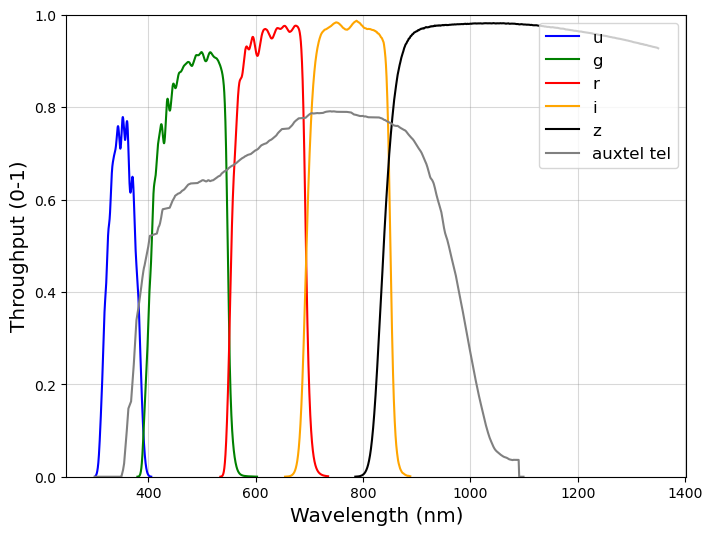

In [8]:
# Plot the curves .. see what we have. 
filtercolors = {'u':'b', 'g':'g', 'r':'r', 'i':'orange', 'z':'k', 'y':'grey'}

plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(sdss_p[f].wavelen, sdss_p[f].sb, color=filtercolors[f], label=f)
    
plt.plot(tel_auxtel.wavelen, tel_auxtel.sb, color="grey", label="auxtel tel")

plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')

In [9]:
tr_u = np.interp(sdss_p["u"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_g = np.interp(sdss_p["g"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_r = np.interp(sdss_p["r"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_i = np.interp(sdss_p["i"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_z = np.interp(sdss_p["z"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)

In [10]:
auxtel = {}
auxtel["u"] = Bandpass(wavelen=sdss_p["u"].wavelen,sb=tr_u * sdss_p["u"].sb)
auxtel["g"] = Bandpass(wavelen=sdss_p["g"].wavelen,sb=tr_g * sdss_p["g"].sb)
auxtel["r"] = Bandpass(wavelen=sdss_p["r"].wavelen,sb=tr_r * sdss_p["r"].sb)  
auxtel["i"] = Bandpass(wavelen=sdss_p["i"].wavelen,sb=tr_i * sdss_p["i"].sb)  
auxtel["z"] = Bandpass(wavelen=sdss_p["z"].wavelen,sb=tr_z * sdss_p["z"].sb)  

Text(0.5, 1.0, 'Auxtel Photometry')

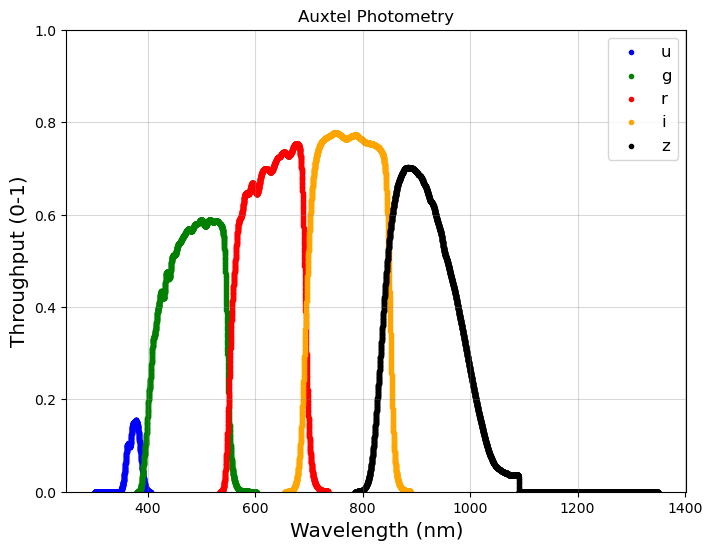

In [11]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.scatter(auxtel[f].wavelen, auxtel[f].sb, color=filtercolors[f],marker='.' ,label=f)
    
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.title("Auxtel Photometry")

## Find boundaries and borders of filters

Text(0, 0.5, 'number of bins')

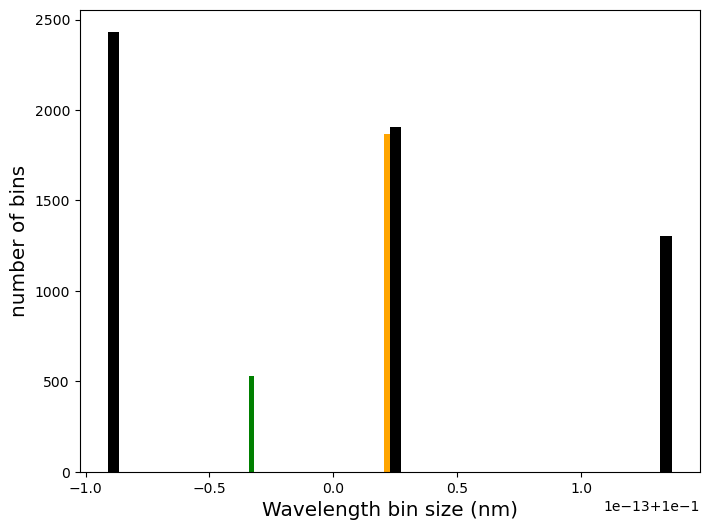

In [12]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.hist(np.diff(auxtel[f].wavelen),bins=50, facecolor=filtercolors[f], label=f)

plt.xlabel("Wavelength bin size (nm)", fontsize='x-large')
plt.ylabel("number of bins", fontsize='x-large')

In [13]:
FILTERS = np.zeros((len(filterlist),4))

transm_thr = 0.01
for idx,f in enumerate(filterlist):
    indexes = np.where(auxtel[f].sb>transm_thr)[0]
    wls = auxtel[f].wavelen[indexes]
    WLMIN = wls.min()
    WLMAX = wls.max()
    WLMEAN = wls.mean()
    WLWIDTH = WLMAX - WLMIN
    FILTERS[idx,0] = WLMIN
    FILTERS[idx,1] = WLMAX
    FILTERS[idx,2] = WLMEAN
    FILTERS[idx,3] = WLWIDTH
    print(f,wls.min(),wls.max(),np.mean(np.diff(wls)))

u 352.7 395.9 0.09999999999999998
g 387.6 566.2 0.10000000000000002
r 541.4 715.5 0.10000000000000002
i 673.3 870.9 0.1
z 805.6 1090.7 0.1


In [14]:
FILTERS

array([[ 352.7 ,  395.9 ,  374.3 ,   43.2 ],
       [ 387.6 ,  566.2 ,  476.9 ,  178.6 ],
       [ 541.4 ,  715.5 ,  628.45,  174.1 ],
       [ 673.3 ,  870.9 ,  772.1 ,  197.6 ],
       [ 805.6 , 1090.7 ,  948.15,  285.1 ]])

Text(0.5, 1.0, 'Auxtel Photometry')

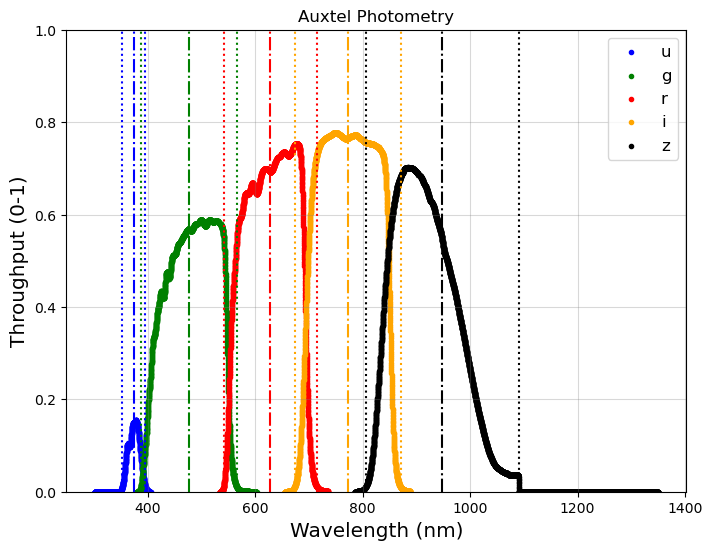

In [15]:
plt.figure(figsize=(8,6))
for idx,f in enumerate(filterlist):
    plt.scatter(auxtel[f].wavelen, auxtel[f].sb, color=filtercolors[f],marker='.' ,label=f)
    plt.axvline(FILTERS[idx,0],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,1],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,2],color=filtercolors[f],linestyle="-.")
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.title("Auxtel Photometry")

# Need to resample

- rubinsim assure really regular grid for wavelengths otherwise it generate an error in sed.py
- thus the transmission curve is resampled using a wavelength grid of 0.1 nm

In [16]:
step_wl = 0.1

In [17]:
auxtel_sdss = {}
for idx,f in enumerate(filterlist):
    WL = np.arange(FILTERS[idx,0],FILTERS[idx,1],step_wl)
    tr = np.interp(WL, auxtel[f].wavelen, auxtel[f].sb)
    auxtel_sdss[f] =  Bandpass(wavelen=WL,sb=tr)

Text(0.5, 1.0, 'Auxtel Photometry resampled')

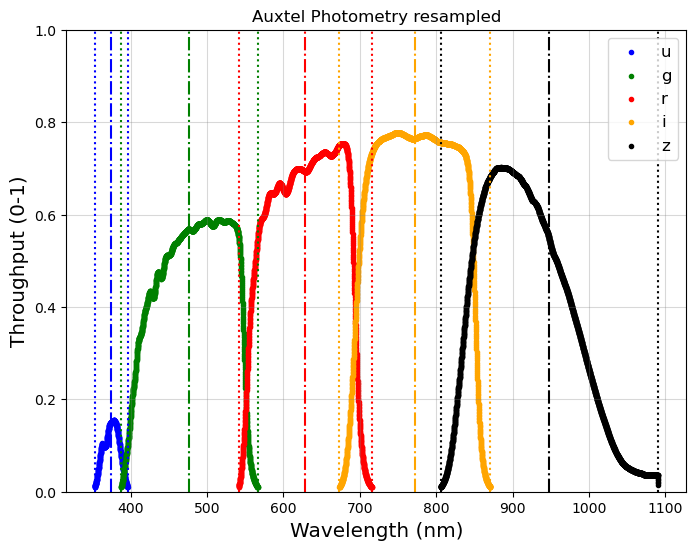

In [18]:
plt.figure(figsize=(8,6))
for idx,f in enumerate(filterlist):
    plt.scatter(auxtel_sdss[f].wavelen, auxtel_sdss[f].sb, color=filtercolors[f],marker='.' ,label=f)
    plt.axvline(FILTERS[idx,0],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,1],color=filtercolors[f],linestyle=":")
    plt.axvline(FILTERS[idx,2],color=filtercolors[f],linestyle="-.")
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.title("Auxtel Photometry resampled")

# Save File

In [19]:
for f in filterlist:
    filename = f"auxtel_sdss_{f}.dat"
    fullfilename = os.path.join(fdir,filename)
    auxtel_sdss[f].write_throughput(fullfilename)